In [40]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon
import matplotlib.lines as mlines
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json
import numpy as np
import os
from pathlib import Path
import re
import scipy.constants as constants

import analysis
import analysis_utils as utils

import pandas as pd

In [2]:
# === Directory config ===
data_dir = Path('/home/marksta/scratch/jep-2025-revision')
plot_dir = utils.ensure_directory('plots')
reference_dir = Path('./reference')

cases = {
    'Explicit': {'dir': 'g1-dt1-si0-ppc75'},
    '2x': {'dir': 'g2-dt2-si8-ppc75'},
    '4x': {'dir': 'g4-dt4-si16-ppc75'},
    '8x': {'dir': 'g8-dt8-si8-ppc75'},
}

baseline_case = list(cases.keys())[0]

quantities =  {
    'Ex': {'tex': "$E_{x}$", 'unit': 'kV/m', 'name': 'Electric field', 'min': -5, 'max': 60},
    'ni': {'tex': "$n_{i}$", 'unit': 'm$^{-3}$', 'name': 'Number density', 'min': 0}, 
    'Te': {'tex': '$T_{e}$', 'unit': 'eV', 'name': 'Electron temperature', 'min': 0},
}

var_names = {
    'si': 'Semi-implicit factor',
    'dt': '$\Delta t$ / (5$\\times10^{-12}$ s)',
    'g': '$\Delta x$ / (5$\\times10^{-5}$ m)',
    'ppc': 'Initial particles/cell',
}


In [134]:
colors = ['black', '#30a2da', "#fc4f30", "#e5ae38", "#6d904f"]
x_locs = [0.3, 1.75]
patch_color = '#cccccc'
start_time = 12e-6

In [4]:
# == Common utilities ===
def _load_averaged_data(dir: Path | str):
    data = np.genfromtxt(Path(dir) / 'output' / 'extracted.csv', delimiter=',')
    return {'x': data[0, :], 'ni': data[1, :], 'ne': data[2, :], 'Ex': data[3, :], 'Te': data[4, :], 'ui': data[5, :], 'ue': data[6, :]}

def _parse_sim_name(name: str) -> dict[str, int] | None:
    regex = r"g([0-9]+)-dt([0-9]+)-si([0-9]+)-ppc([0-9]+)"
    prog = re.compile(regex)
    match = prog.fullmatch(name)

    if match:
        return {
            'g': int(match.group(1)),
            'dt': int(match.group(2)),
            'si': int(match.group(3)),
            'ppc': int(match.group(4)),
        }
    else:
        return None

def _find_other_sims(base, variable, dir):
    sims = os.listdir(dir)

    # Get variables of our base sim
    base_vars = _parse_sim_name(base)

    def _match_pred(sim: str) -> bool:
        # Match simulations that share all variables in common with our base sim
        # except for the chosen sweep variable
        vars = _parse_sim_name(sim)
        if vars is None:
            return False, None

        for (k, v) in vars.items():
            if k == variable:
                continue

            if v != base_vars[k]:
                return False, None
        return True, vars

    # Find all sims matching the above predicate
    sims = [(sim_dir, match[1]) for sim_dir in os.listdir(dir) if (match := _match_pred(sim_dir))[0]]

    # Sort by target variable
    sims.sort(key=lambda x: x[1][variable])
    
    return sims



In [5]:
case_data = {
    casename: analysis.DataSeries(data_dir / case['dir'] / 'diags', start_time = 18e-6)
    for casename, case in cases.items()
}

In [6]:
# === Matplotlib config ===
font = {"family": "DejaVu Sans", "weight": "normal", "size": 15}
plt.set_loglevel("error")
plt.rc("font", **font)
benchmark_color = "#ffb3b3"
fig_dpi = 200
savefig_args = {'bbox_inches': 'tight', 'dpi': fig_dpi, 'dir': plot_dir, 'filetypes': ['png', 'eps']}

def save_fig(fig, name: str, filetypes: list[str] = ["png"], dir: Path | str = Path("."), **args):
    output_dir = Path(dir)
    for ft in filetypes:
        fig.savefig(output_dir / f"{name}.{ft}", **args)
        

# Plot 0: Comparison of 2x, 4x, 8x cases to explicit case

In [153]:
def _benchmark_comparison_qty(fig, ax, qty_name, qty, data, letter):

    ax.set_xlabel('x [cm]')
    ax.set_ylabel(f"{qty['name']} [{qty['unit']}]")
    ax.autoscale(enable=True, axis='x', tight=True)
    ax.axhline(0, color = 'gray')
    bline = ax.axvline(0.75, color = 'black', linestyle = '--')
    ax.text(
        0.96, 0.96, f'({letter})',
        horizontalalignment='right',
        verticalalignment='top',
        transform = ax.transAxes,
        size=25
    )

    # Use math formatter for y axis
    formatter = mticker.ScalarFormatter(useMathText=True)
    ax.yaxis.set_major_formatter(formatter)

    # Load relevant reference polygon
    _, _, ref_poly = utils.make_ref_polygon(qty_name, reference_dir) 
    patch  = ax.add_patch(
        Polygon(ref_poly, color=patch_color, label="Benchmark", zorder=0)
    )

    lines = [patch, bline]
    labels = ["Benchmark", "Peak magnetic field"]

    for color, (key, data) in zip(colors, data.items()):
        labels.append(key)
        line, = ax.plot(data['x'], data[qty_name], color)
        lines.append(line)
    
    bottom = qty.get('min')
    top = qty.get('max')
    
    if bottom is not None:
        ax.set_ylim(bottom=bottom)
    if top is not None:
        ax.set_ylim(top=top)

    return lines, labels

def plot_benchmark_comparison(show=False):
    fig, axes = plt.subplots(1,3, layout = 'constrained', figsize = (12, 4))

    data = {casename: _load_averaged_data(data_dir / case['dir']) for casename, case in cases.items()} 

    for ax, letter, (qty_name, qty) in zip(axes.flatten(), 'abc', quantities.items()):
        lines, labels = _benchmark_comparison_qty(fig, ax, qty_name, qty, data, letter)
    
    fig.legend(
         lines, labels, loc='lower left', ncol=6,
         bbox_to_anchor = (0.05, 1.02, 0.95, .102),
         mode='expand',
         bbox_transform = fig.transFigure,
         borderaxespad=0.
    )
    
    save_fig(fig, "benchmark_comparison", **savefig_args)
    
    if show:
        plt.show()
    else:
        plt.close(fig)

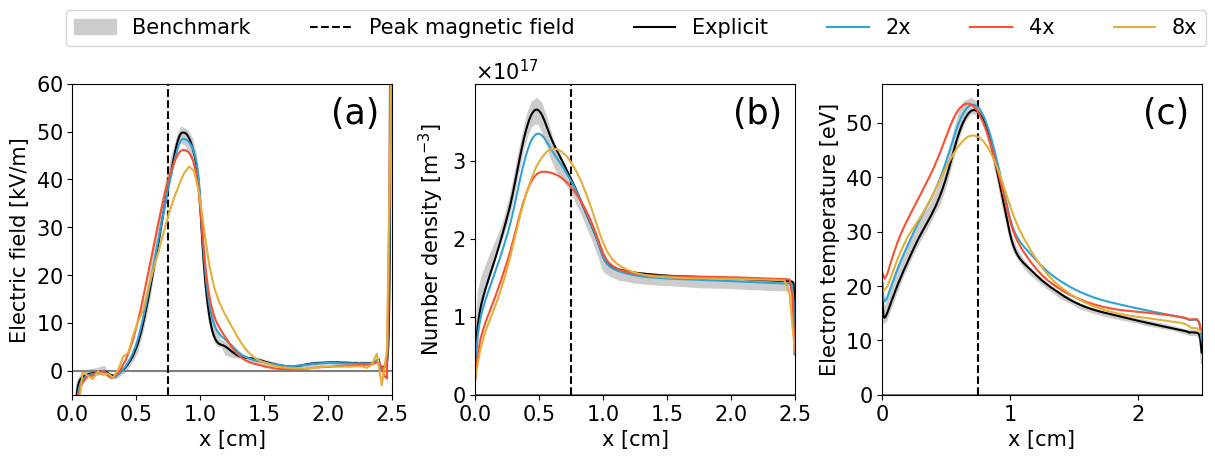

In [154]:
plot_benchmark_comparison(show=True)

# Plot 2.1: Convergence of electron current at anode

In [268]:
def plot_qoi_convergence(variable, qoi, show=False):
    def _qoi(data, name):
        if qoi == 'je':
            return _relative_cathode_current_density(data)
        else:
            return np.mean(data['Te'])
            
    def _relative_cathode_current_density(data):
        e = constants.e
        x_avg = (2.2, 2.39)
        JM = 400
        x = data['x']
        ne = data['ne']
        ue = data['ue']
        j_e = -ne * ue * e
        x_window = np.logical_and(x > x_avg[0], x < x_avg[1])
        return np.mean(j_e[x_window]) / JM * 100

    Te_lo, Te_hi, _ = utils.make_ref_polygon('Te', reference_dir)
    mean_Te_lo = np.mean(Te_lo[:, 1])
    mean_Te_hi = np.mean(Te_hi[:, 1])

    test_cases = ['2x', '4x', '8x']
    baseline = _load_averaged_data(data_dir / cases[baseline_case]['dir'])
    baseline_vars = _parse_sim_name(cases[baseline_case]['dir'])

    test_data = {
        case: [(vars, _load_averaged_data(data_dir / dir)) for (dir, vars) in _find_other_sims(cases[case]['dir'], variable, data_dir)]
        for case in test_cases
    }

    benchmark_range = [67, 97]

    jecs = {baseline_vars[variable]: [_qoi(baseline, qoi)]}
    xs = {baseline_vars[variable]: [1]}

    fig, ax = plt.subplots(1,1, layout = 'constrained', figsize = (5,4))
    for (casename, case) in test_data.items():
        for (vars, case_data) in case:
            var = vars[variable]
            if var not in xs:
                xs[var] = []
                jecs[var] = []
            xs[var].append(vars['g'])
            jecs[var].append(_qoi(case_data, qoi))

    for (i, (k, v)) in enumerate(xs.items()):
        ax.plot(v, jecs[k], '.-', color = colors[i], markersize=15, label = f"{k}")
        print(jecs[k])
        break
        
    ax.set_xticks([1,2,4,8])
    if qoi == 'je':
        ax.set_ylabel('$J_{ec}\\;/\\;J_M$ [%]')
        ax.axhspan(ymin = benchmark_range[0], ymax = benchmark_range[1], color = patch_color, zorder=0)
        ax.set_ylim(top=100)
    else:
        ax.set_ylabel('$\\langle T_e\\rangle$')
        ax.axhspan(ymin = mean_Te_lo, ymax = mean_Te_hi, color = patch_color, zorder=0)
        ax.set_ylim(top=30)

    ax.set_xlabel('Cell size / ($5\\times10^{-5}$ m)')
    ax.set_ylim(bottom=0)
    #ax.legend(title = var_names[variable], ncol=2)

    if qoi == 'je':
        save_fig(fig, f"cathode_current_{variable}", **savefig_args)
    else:
        save_fig(fig, f"electron_temp_{variable}", **savefig_args)

    if show:
        plt.show()
    else:
        plt.close(fig)


[83.79019855411671, 100.79203602206024, 128.41094008179235, 105.69986863791925]


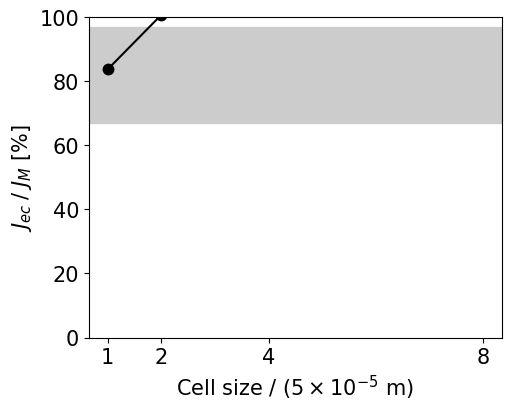

In [269]:
plot_qoi_convergence('dt', 'je', show=True)

[83.79019855411671]


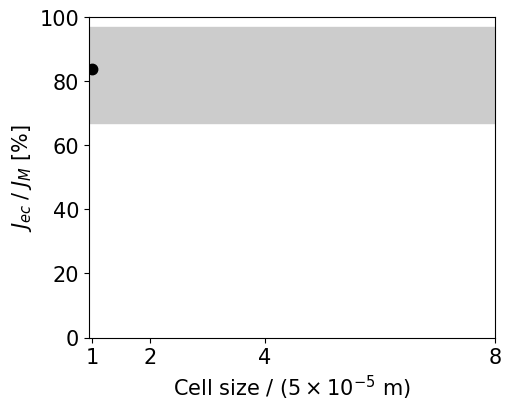

In [270]:
plot_qoi_convergence('si', 'je', show=True)

[83.79019855411671, 88.59033731743793, 79.6019618037167, 27.419099506485118]


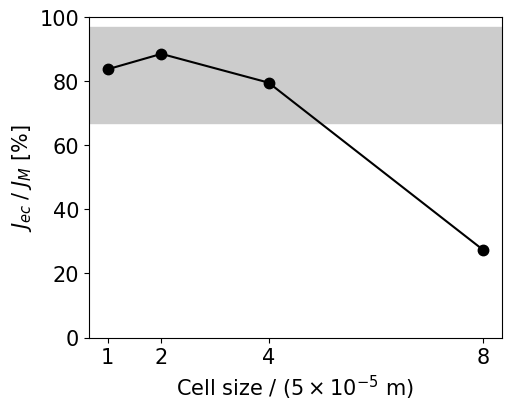

In [271]:
plot_qoi_convergence('ppc', 'je', show=True)

[24.210377132972067, 26.86041845768675, 30.247789359911618, 29.680764137415874]


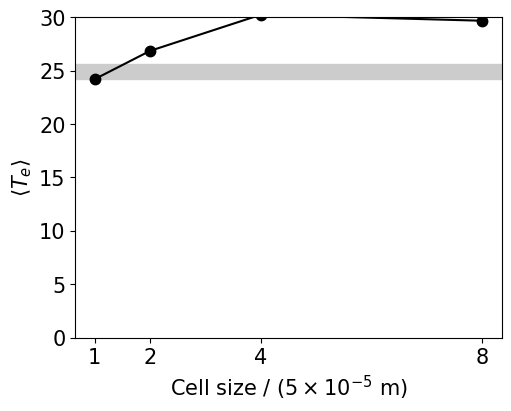

In [272]:
plot_qoi_convergence('dt', 'Te', show=True)

[24.210377132972067]


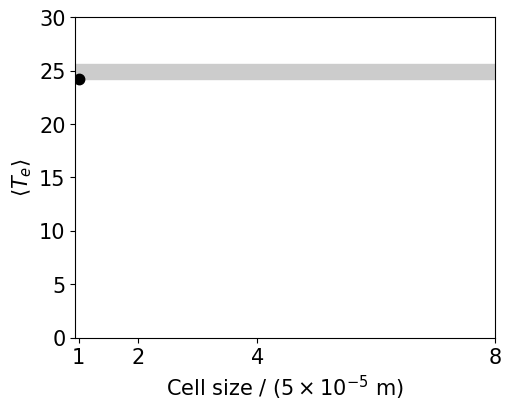

In [273]:
plot_qoi_convergence('si', 'Te', show=True)

[24.210377132972067, 26.583433190977136, 27.029223856236758, 25.473592533485533]


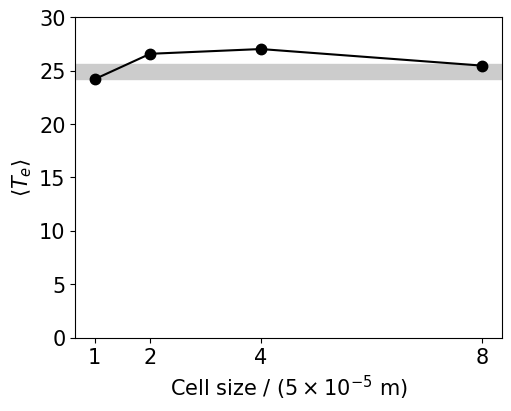

In [274]:
plot_qoi_convergence('ppc', 'Te', show=True)

# Plot 3.1: Performance of individual sections of the codes

In [151]:
timings = {
    75: {'wall_hours': 1.81 * 24, 'push': 0.4881, 'field': 0.4086, 'deposit': 0.0843, 'python': 0.0109},
    150: {'wall_hours': 2.86 * 24, 'push': 0.6379, 'field': 0.2421, 'deposit': 0.1072, 'python': 0.0128},
    300: {'wall_hours': 5.06 * 24, 'push': 0.7311, 'field': 0.1663, 'deposit': 0.0963, 'python': 0.0063},
}

def plot_performance(show=False):

    fig, ax = plt.subplots(figsize=(6,5))
    ax.set_ylabel("Time [hours]")
    ax.set_xlabel("Initial particles per cell")
    
    width = 0.5

    weights = {
        "Python callbacks": np.array([x['python'] for x in timings.values()]),
        "Deposit charge": np.array([x['deposit'] for x in timings.values()]),
        "Field solve": np.array([x['field'] for x in timings.values()]),
        "Gather and push": np.array([x['push'] for x in timings.values()]),
    }

    total_times = np.array([x['wall_hours'] for x in timings.values()])

    xs = range(len(total_times))

    ax.set_xticks(xs, timings.keys())

    bottoms = np.zeros(len(total_times))

    bars = []
    labels = []
    for color, (label, weight) in zip(reversed(colors[1:]), weights.items()):
        incr = total_times * weight
        bar = ax.bar(xs, incr, bottom=bottoms, label=label, color = color)
        bars.append(bar)
        labels.append(label)
        bottoms += incr 

    bars.reverse()
    labels.reverse()

    ax.legend(bars, labels)

    save_fig(fig, "performance", **savefig_args)
    if show:
        plt.show()
    else:
        plt.close(fig)

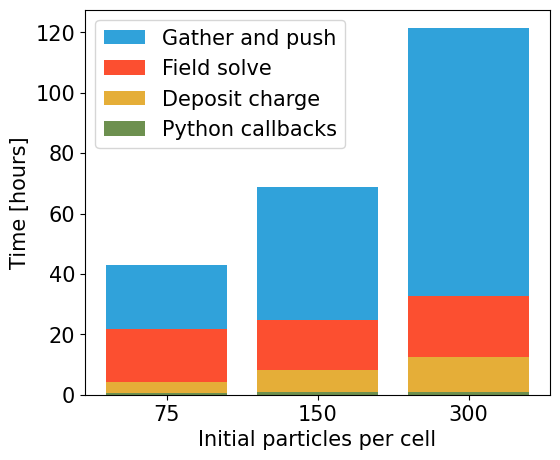

In [150]:
plot_performance(show=True)

# Plot 3.2: Roofline plots

In [65]:
metric_names_backward = {
    'DRAM_bytes': 'dram__bytes.sum',
    'L2_bytes': 'l1tex__t_bytes.sum',
    'L1_bytes': 'lts__t_bytes.sum',
    'cycles_per_s': 'sm__cycles_elapsed.avg.per_second',
    'cycles_elapsed': 'sm__cycles_elapsed.avg',
    'dadd': 'sm__sass_thread_inst_executed_op_dadd_pred_on.sum',
    'dfma': 'sm__sass_thread_inst_executed_op_dfma_pred_on.sum',
    'dmul': 'sm__sass_thread_inst_executed_op_dmul_pred_on.sum',
    'fadd': 'sm__sass_thread_inst_executed_op_fadd_pred_on.sum',
    'ffma': 'sm__sass_thread_inst_executed_op_ffma_pred_on.sum',
    'fmul': 'sm__sass_thread_inst_executed_op_fmul_pred_on.sum',
}

metric_names = {
    v: k for (k, v) in metric_names_backward.items()
}

def empty_metrics(): 
    return {
        k: 0.0 for k in metric_names.values()
    }
    
def read_metrics(file):
    contents = None
    with open(Path(file), "r") as fd:
        for line in fd:
            if line.startswith("==PROF== Disconnected from process"):
                break
        contents = pd.read_csv(fd)

    if contents is None:
        raise ValueError("Invalid file")

    metrics = empty_metrics()

    total_kernels = 0

    for (i, row) in contents.iterrows():
        metric_name = row['Metric Name']
        metric_val = row['Metric Value']
        if metric_name not in metric_names.keys():
            continue

        short_name = metric_names[metric_name]
        if short_name == 'cycles_per_s':
            total_kernels += 1

        if isinstance(metric_val, str):
            metric_val = float(metric_val.replace(",", ""))
        
        metrics[short_name] += metric_val

    metrics['cycles_per_s'] /= total_kernels

    return metrics

In [291]:
def calc_roofline_metrics(metrics):
    time_s = metrics['cycles_elapsed'] / metrics.get('cycles_per_s', 1.59)
    flops = metrics.get('dfma', 0) + metrics.get('dmul', 0) + metrics.get('dadd',0) + \
            metrics.get('ffma', 0) + metrics.get('fadd', 0) + metrics.get('fmul', 0)

    intensity = {
        key: flops / metrics[f'{key}_bytes'] for key in ['L1', 'L2', 'DRAM']
    }
    
    perf = flops / time_s
    return intensity, perf

def plot_roofline(metrics, names = [], show=False):
    flops_h100_sp = 67e12
    flops_h100_dp = 34e12

    bandwidths = {
        'DRAM': 3.35e12,
        'L2': 12e12,
        'L1': 33e12,
    }
    
    fig, ax = plt.subplots(figsize=(6,5))
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_xlabel("Arithmetic intensity (FLOP/Byte)")
    ax.set_ylabel("Performance (TFLOP/second)")

    scale = 1e12

    intensity = 10**np.linspace(-2, 3, 100)

    for key, bandwidth in bandwidths.items():
        max_intensity_sp = flops_h100_sp / bandwidth
        max_intensity_dp = flops_h100_dp / bandwidth
        perf_sp = intensity * bandwidth
        perf_sp[intensity > max_intensity_sp] = flops_h100_sp
        perf_sp /= scale
        ax.plot(intensity, perf_sp, color = 'black')
    
        perf_dp = intensity * bandwidth
        perf_dp[intensity > max_intensity_dp] = flops_h100_dp
        perf_dp /= scale
        ax.plot(intensity, perf_dp, color = 'black')

        ind = 4
        angle = np.rad2deg(np.arctan2(perf_dp[1] - perf_dp[0], intensity[1] - intensity[0]))
        ax.text(
            intensity[ind], perf_dp[ind], f"{key} ({bandwidth / 1e12:.1f} TB/s)",
            ha = 'left', va = 'bottom',
            size = 12,
            rotation = angle,
            rotation_mode='anchor',
            transform_rotates_text=True
        )


    ax.text(
        intensity[-1],
        flops_h100_dp / scale,
        "Double (34 TFLOPs)",
        ha = 'right',
        va = 'bottom',
        size = 12,
    )

    ax.text(
        intensity[-1],
        flops_h100_sp / scale,
        "Single (67 TFLOPs)",
        ha = 'right',
        va = 'bottom',
        size = 12,
    )

    ax.margins(y = 0.1)
    ax.set_xlim(intensity[0], intensity[-1])

    markersize = 8
    
    markers = {
        'L1': 'o',
        'L2': 's',
        'DRAM': 'v',
    }
    scatter_args = {
        's': markersize**2, 'facecolors': 'none'
    }

    # add dummy plots for legend entries
    for (label, marker) in markers.items():
        ax.scatter([10 * intensity[-1]], [flops_h100_sp/scale], edgecolor = 'black', marker=marker, label = label, **scatter_args)

    cs = colors[1:]
    
    for (i, metric) in enumerate(metrics):
        intensity, perf = calc_roofline_metrics(metric)
        perf /= scale
        
        intensities = []
        for (key, marker) in markers.items():
            intens = intensity[key]
            intensities.append(intens)
            markersize = 8
            ax.scatter([intens], [perf], edgecolor = cs[i], zorder=5, marker=marker, **scatter_args)

        label = names[i] if len(names) == len(metrics) else ""
        ax.plot(intensities, [perf]*3, zorder=4, color = cs[i]) #, label = label)

    if len(names) == len(metrics):
        # Add legend for kernels
        handles = [mlines.Line2D([0, 0], [0,0], color=color) for color in cs]
        leg1 = ax.legend(handles, names, loc='lower right')
        ax.add_artist(leg1)

    # Add legend for memory
    ax.legend(loc = 'center right')

    save_fig(fig, "roofline_1x", **savefig_args)

    if show:
        plt.show()
    else:
        plt.close(fig)

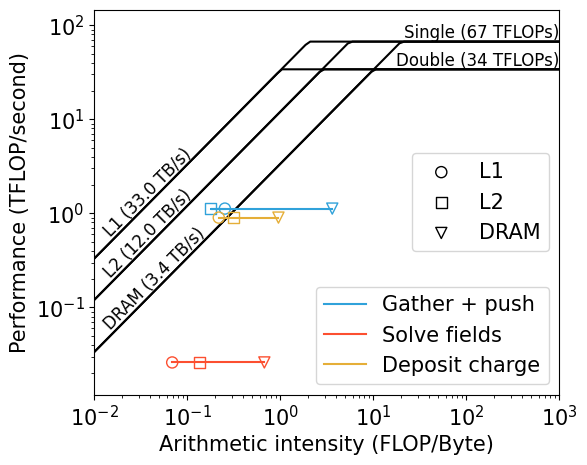

In [292]:
ncu_dir = Path("/home/marksta/scratch/nsight-profiling/run")

metric_files = [
    'push_1x.csv',
    'mlmg_1x.csv',
    'deposit_1x.csv',
]
metrics = [read_metrics(ncu_dir / file) for file in metric_files]
plot_roofline(metrics, ['Gather + push', 'Solve fields', 'Deposit charge'], show=True)

# Plot 4: IVDF for each of the selected cases

In [261]:
def _ivdf_load_data():
    def _load_case_data(dir: Path | str):
        vdf_file = Path(dir) / "output" / "vdf" / "vdf_ions_x.csv"
        with open(vdf_file, "r") as fd:
            header = fd.readline()[1:].strip()
            extent = [float(x) for x in header.split(',')]
            
        hists = np.genfromtxt(vdf_file, delimiter = ",")
        return extent, hists 

    for case, case_data in cases.items():
        dir = data_dir / case_data['dir']
        extent, vdfs = _load_case_data(dir)
        case_data['extent'] = extent
        case_data['vdfs'] = vdfs

    return cases

def ivdf_plot(output_dir = Path("."), show=False):
    cases = _ivdf_load_data()
    case_names = list(cases.keys())
    fig, axes = plt.subplots(2,2, figsize = (11,7), layout='compressed')

    case_pos = (0.96, 0.04)

    case1 = cases[case_names[0]]
    _ , _, umin, umax = case1['extent']
    nbins, nx = np.shape(case1['vdfs'])
    bin_centers = np.linspace(umin, umax, nbins+1)
    bin_centers = 0.5 * (bin_centers[:-1] + bin_centers[1:])
    # Compute most probable velocity as average of vdf**4 (much more strongly peaked version of vdf)
    u_most_prob = [np.average(bin_centers, weights=(case1['vdfs'][:, i])**4) for i in range(nx)]
    x = np.linspace(0, 2.5, nx+1)
    x = 0.5 * (x[:-1] + x[1:])
    
    for ax, (case_name, case_data), letter in zip(axes.flatten(), cases.items(), 'abcd'):
        im = ax.imshow(case_data['vdfs']**0.5, extent = case_data['extent'], origin = 'lower', aspect = 'auto', cmap = 'inferno')
        fontdict = {'color': 'white', 'size': 25}
        ax.text(
            case_pos[0], case_pos[1], f'({letter}) {case_name}', 
            horizontalalignment='right',
            verticalalignment='bottom',
            transform = ax.transAxes,
            **fontdict
        )
        ax.axhline(0, color = 'gray')

        # Plot most probable velocity from 1x case
        ax.set_ylim(-6, 20)
        ax.plot(x, u_most_prob, color = 'white', linestyle = '--')
        ax.set_xticks([0,1,2])
        
        if letter == 'b' or letter == 'd':
            # remove y-axis labels
            plt.setp(ax.get_yticklabels(), visible=False)
        else:
            ax.set_ylabel('Ion velocity [km/s]')
            
        if letter == 'a' or letter == 'b':
            # remove x-axis labels
            plt.setp(ax.get_xticklabels(), visible = False)
        else:
            ax.set_xlabel('x [cm]')

    
    cbar = fig.colorbar(im, ax=axes.ravel().tolist())
    cbar.ax.set_title('a.u.')
    save_fig(fig, "ivdf_2d", **savefig_args)

    if show:
        plt.show()
    else:
        plt.close(fig)

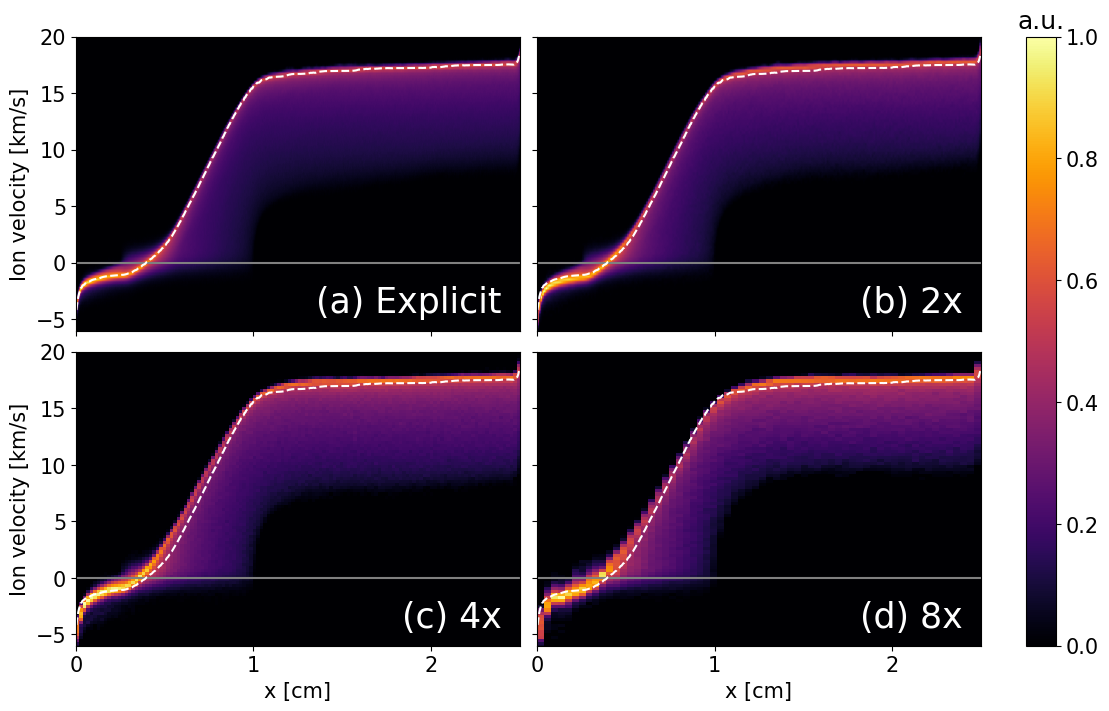

In [262]:
ivdf_plot(show=True)

# Plot 5: Spectral peaks vs location for each case

In [259]:
def kernel(x, center, width):
    mask = np.abs(x - center) <= width
    return mask

def _spectra_load_data(subsample: int | None = None):
    def _load_case_data(dir: Path | str, type: str):
        file = Path(dir) / "output" / f"{type}.json"
        with open(file, "r") as fd:
            data = json.load(fd)

        x = data['x_m']
        amps = data.get('ampitudes', data.get('amplitudes'))
        freqs = data['frequency']
        
        if subsample is not None:
            # interpolate spectra to `subsample`
            xmin, xmax = x[0], x[-1]
            dx = x[1] - x[0]
            
            kernel_width_cells = np.ceil(len(x) / subsample) / 2
            kernel_width_m = dx * kernel_width_cells
    
            x_itp = np.linspace(xmin, xmax, subsample)
            weights = [kernel(x, xc, kernel_width_m) for xc in x_itp]
            weights = np.array([wt / np.sum(wt) for wt in weights])

            amplitudes = np.array(np.abs(amps))
    
            amplitudes_itp = np.abs((amplitudes.T @ weights.T).T)

            data = {'x_m': x_itp, 'frequency': freqs, 'amplitudes': amplitudes_itp.tolist()}
        else:
            data = {'x_m': x, 'frequency': freqs, 'amplitudes': amps}

        
        peak_freqs = [freqs[np.argmax(np.array(amp))] for amp in data['amplitudes']]
        data['peak_freqs'] = peak_freqs
        return data
    
    
    for case, case_data in cases.items():
        dir = data_dir / case_data['dir']
        case_data['frequency'] = _load_case_data(dir, 'frequency')
        case_data['wavenumber'] = _load_case_data(dir, 'wavenumber')

    return cases

def _spectra_plot(ax, spectra, letter: str, type: str, label: str, transform):
    xmin, xmax = 0, 2.5
    subsample=32
    ax.set_xticks([0, 1, 2])
    ax.set_xlim(xmin, xmax)
    ax.set_ylabel(label)
    ax.set_xlabel(f'x [cm]')
    ax.text(0.96, 0.04, f'({letter})',
     horizontalalignment='right',
     verticalalignment='bottom',
     transform = ax.transAxes, size=25)

    _, _, ref_poly = utils.make_ref_polygon(type, reference_dir)

    patch  = ax.add_patch(
        Polygon(ref_poly, color=patch_color, label="Benchmark", zorder=0)
    )

    formatter = mticker.ScalarFormatter(useMathText=True)
    ax.yaxis.set_major_formatter(formatter)

    lines = [patch]
    labels = ["Benchmark range"]
    zorder_max = 6
    for i, ((name, _spectrum), color) in enumerate(zip(spectra.items(), colors)):
        spectrum = _spectrum[type]
        x = np.array(spectrum['x_m']) * 100
        y = transform(np.array(spectrum['peak_freqs']))

        line, = ax.plot(x, y, '.-', markersize=10, color = color, label = name, zorder = zorder_max-i)
        lines.append(line)
        labels.append(name)

        ax.axvline(x_locs[0], color = 'gray', linestyle = '--', zorder=1)
        ax.axvline(x_locs[1], color = 'gray', linestyle = '--', zorder=1)

    ax.set_ylim(bottom=0)
    return lines, labels


def spectral_peak_plot(spectra, show: bool = False):
    fig, axes = plt.subplots(1,2, layout = 'compressed', figsize = (10, 4))
    types = {
        'wavenumber': {'label': '$\lambda_{max}$ [mm]', 'transform': lambda x: 1000 / x},
        'frequency': {'label': '$\omega_{max}$ [rad/s]', 'transform': lambda x: x},
    }

    for ax, letter, (type, info) in zip(axes.flatten(), 'ab', types.items()):
        lines, labels = _spectra_plot(ax, spectra, letter, type, **info)

    fig.legend(
        lines, labels, loc='lower left', ncol=5,
        bbox_to_anchor = (0.05, 1.02, 0.95, .102),
        mode='expand',
        bbox_transform = fig.transFigure,
        borderaxespad=0.
    )
    
    save_fig(fig, "spectral_peaks", **savefig_args)

    if show:
        plt.show()
    else:
        plt.close(fig)

    

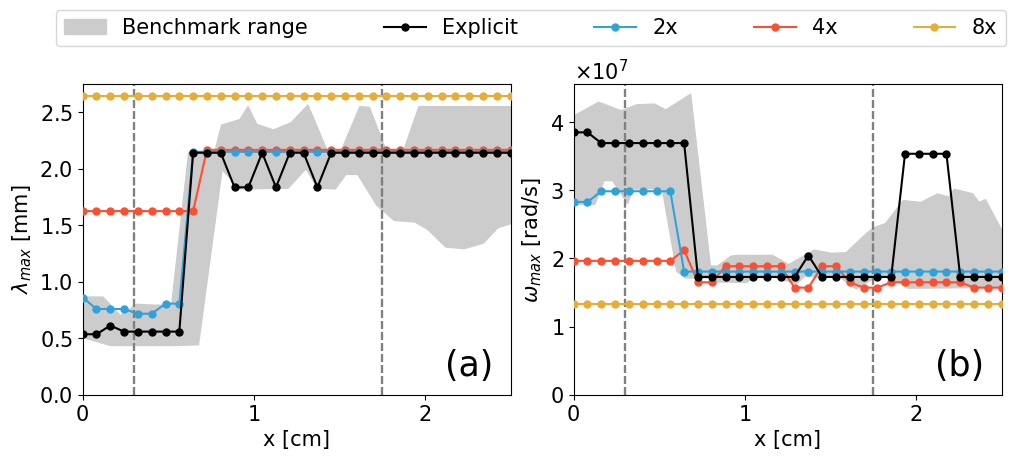

In [260]:
spectra = _spectra_load_data(subsample=32)
spectral_peak_plot(spectra, show=True)

# Plot 6.1: 2D Azimuthal electric fields for each case

In [23]:
def efield_plot_2d(spectra, data, show=False):

    fig = plt.figure(figsize = (10, 8), layout = 'constrained')
    fig, axes = plt.subplot_mosaic([['Explicit', '2x', 'cax'], ['4x', '8x', 'cax']], figsize = (10, 4), width_ratios = [0.9, 0.9, 0.05], layout='constrained')
    
    for letter, case in zip('abcd', cases.keys()):
        _data = case_data[case]
        ax = axes[case]
        Ey = _data.load("Ez", dimension = 2, inds = [len(_data.time)-1], verbose=False)[0]
    
        # Get dimensions (x,y) in cm
        x_cm = _data.data[0].grid1D(axis=0).v * 100
        y_cm = _data.data[0].grid1D(axis=1).v * 100
        left, right = min(x_cm), max(x_cm)
        bottom, top = min(y_cm), max(y_cm)
        # have to flip top and bottom because 'z' in WarpX is '-y' by the benchmark
        extent = (left, right, bottom, top)
    
        Emin = -40
        Emax = 40
        im = ax.imshow(
            Ey / 1000, aspect = 'auto', vmin = Emin, vmax = Emax, extent=extent, cmap = 'RdBu_r'
        ) 
        ax.text(
            0.98, 0.955, f'({letter}) {case}',
            horizontalalignment='right',
            verticalalignment='top',
            transform = ax.transAxes,
            backgroundcolor = 'white',
            size = 15,
        )
        if case == '4x' or case == '8x':
            ax.set_xlabel('x [cm]')
            ax.set_xticks([0, 1, 2])
        else:
            ax.set_xticklabels([])

        if case == 'Explicit' or case == '4x':
            ax.set_ylabel('y [cm]')
        else:
            ax.set_yticklabels([])

        for x in x_locs:
            ax.axvline(x, color = 'black', linewidth = 1, linestyle = '--')

    fig.colorbar(im, cax=axes['cax'], label = "$E_y$ [kV/m$^2$]")

    save_fig(fig, 'efield_2d', **savefig_args)
    
    if show:
        plt.show()
    else:
        plt.close(fig)

<Figure size 1000x800 with 0 Axes>

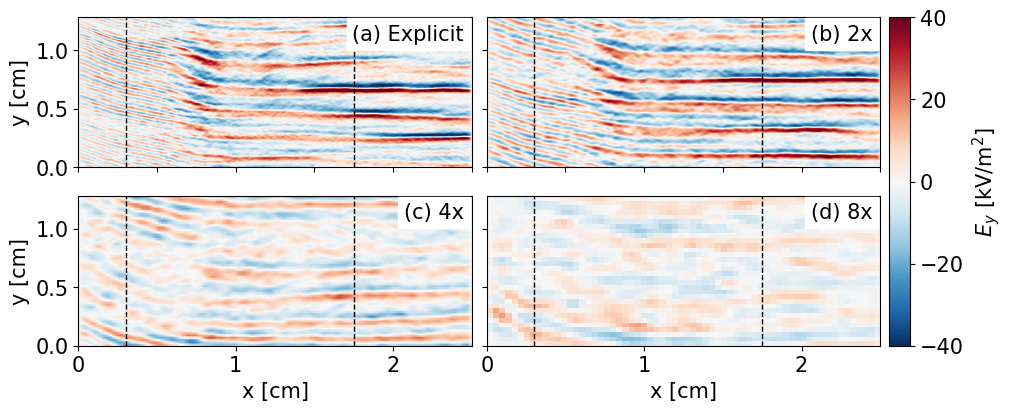

In [24]:
efield_plot_2d(spectra, case_data, show=True)

# Plot 6.2: Fourier transforms at two locations for all four cases

In [159]:
def _spectrum_plot(ax, spectra, pos, letter):
    ax.text(
        0.02, 0.96, f'({letter}) x = {pos} cm',
        horizontalalignment='left',
        verticalalignment='top',
        transform = ax.transAxes, size=20
    )

    low, hi, _ = utils.make_ref_polygon('wavenumber', ref_dir = reference_dir)

    lo_x, lo_lambda = low[:, 0], low[:, 1]
    hi_x, hi_lambda = hi[:, 0], hi[:, 1]

    lambda_lo = np.interp(pos, lo_x, lo_lambda)
    lambda_hi = np.interp(pos, hi_x, hi_lambda)
    patch = ax.axvspan(xmin = lambda_lo, xmax = lambda_hi, color = patch_color)

    lines = [patch]
    labels = ['Benchmark $\lambda_{max}$']
    
    for color, (name, s) in zip(colors, spectra.items()):
        ax.set_xlabel('Wavelength [mm]')
        k_spectrum = s['wavenumber']
        x = np.array(k_spectrum['x_m'])
        ind = np.argmax(x > (pos / 100))
        t = (pos/100 - x[ind-1]) / (x[ind] - x[ind-1])

        k = np.array(k_spectrum['frequency'])
        amps = k_spectrum['amplitudes']
        amplitude = (1 - t) * np.array(amps[ind-1]) + t * np.array(amps[ind])

        line, = ax.loglog(1/k * 1000, amplitude, color=color)
        lines.append(line)
        labels.append(name)
        ax.set_xlim(left = 0.1, right=10)
        ax.set_ylim(bottom=1e3, top=4e6)

    return lines, labels
    
def spectra_plot(show=False):
    fig, axes = plt.subplot_mosaic([['legend', 'legend'],['left', 'right']], layout = 'constrained', figsize = (9, 4), height_ratios = [0.1, 1])
    
    for (i, (ax, x, letter)) in enumerate(zip([axes['left'], axes['right']], x_locs, 'ab')):
        lines, labels = _spectrum_plot(ax, spectra, x, letter)
        if i == 0:
            ax.set_ylabel('|$\hat{E_y}$| [V/m]')
        else:
            ax.set_yticklabels([])

    axes['legend'].axis('off')
    axes['legend'].legend(
        lines,
        labels,
        ncol = len(labels),
        loc='upper left',
        bbox_to_anchor = [0.0, 1.0, 1.0, 0.1],
        bbox_transform = axes['legend'].transAxes,
        mode = 'expand',
        borderaxespad = 0.
    )

    save_fig(fig, 'wavelength_spectra', **savefig_args)

    if show:
        plt.show()
    else:
        plt.close(fig)


/tmp/ipykernel_3433698/2515618850.py:12: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.savefig(output_dir / f"{name}.{ft}", **args)


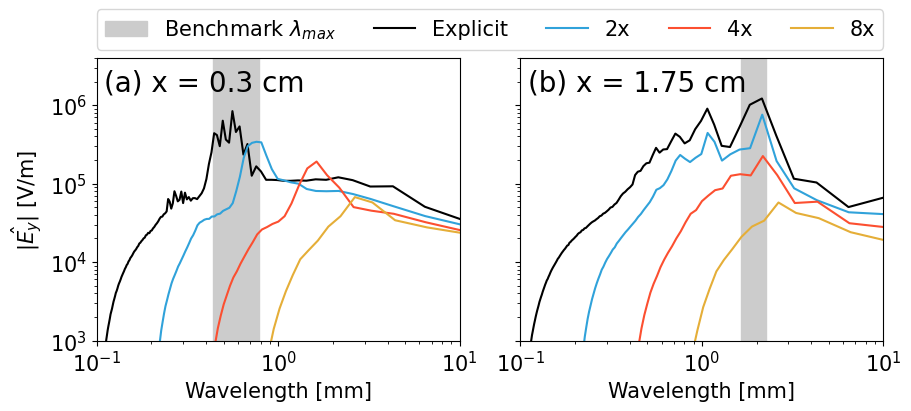

In [160]:
spectra_plot(True)

# 7, 8, 9. Quantified deviation from baseline as a function of initial ppc, semi-implicit factor, timestep

In [255]:
def _calc_deviation(base, test, quantity):
    x_base = base['x']
    mask = np.logical_and(x_base > 0.1, x_base < 2.4)

    y_base = base[quantity]
    x_test = test['x']
    y_test = test[quantity]
    y_test_itp = np.interp(x_base, x_test, y_test)
    
    return np.sqrt(np.sum((y_base[mask] - y_test_itp[mask])**2) / np.sum(y_base[mask]**2))

def _plot_deviation_qty(fig, ax, variable, qty, baseline, test_data, letter):

    width = 0.3
    keys = list(test_data.keys())
    x = np.arange(len(keys))

    tick_x = []
    tick_labels = []


    for (i, (key, all_data)) in enumerate(test_data.items()):
        xs = []
        ys = []
        hatch = []
        num_items = len(all_data)
        max_deviation = 0.0

        base = _parse_sim_name(cases[key]['dir'])
        
        for j, (vars, data) in enumerate(all_data):
            deviation = _calc_deviation(baseline, data, qty) * 100

            x_bar = x[i] + j*width
            xs.append(x_bar)
            ys.append(deviation)
            tick_labels.append(vars[variable])

            if base[variable] == vars[variable]:
                hatch.append("//")

                ax.text(
                    x_bar, deviation, key,
                    horizontalalignment='center',
                    verticalalignment='bottom',
                    color = colors[i+1]
                )
            else:
                hatch.append("")

        ax.bar(np.array(xs), np.array(ys), width=width, linewidth=1, edgecolor='black', color = colors[i+1], hatch=hatch)
        tick_x += xs

    rotation = -70 if variable == 'ppc' else 0
    ax.set_xticks(tick_x, tick_labels, rotation=rotation)
    ax.set_xlabel(var_names[variable])
    ax.set_ylim(0, 30)
    ax.text(
        0.02, 0.96, f"({letter}) {quantities[qty]['tex']}",
        horizontalalignment='left',
        verticalalignment='top',
        transform = ax.transAxes, size=20
    )


def plot_deviations(variable, letters='abc', show=False):
    fig, axes = plt.subplots(1, 3, figsize = (10, 3), layout = 'constrained', sharey = True)
    test_cases = ['2x', '4x', '8x']
    baseline = _load_averaged_data(data_dir / cases[baseline_case]['dir'])

    test_data = {
        case: [(vars, _load_averaged_data(data_dir / dir)) for (dir, vars) in _find_other_sims(cases[case]['dir'], variable, data_dir)]
        for case in test_cases
    }
    
    for (ax, qty, letter) in zip(axes.flatten(), quantities.keys(), letters):
        _plot_deviation_qty(fig, ax, variable, qty, baseline, test_data, letter)

    axes[0].set_ylabel('Average deviation (%)')
    save_fig(fig, f"deviations_{variable}", **savefig_args)
    
    if show:
        plt.show()
    else:
        plt.close(fig)

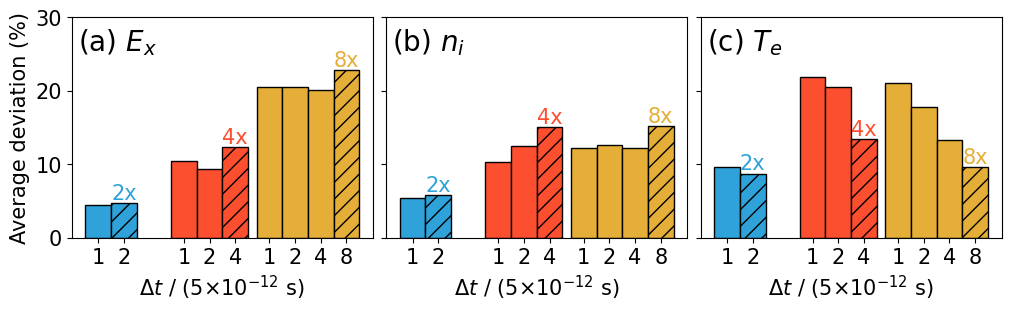

In [256]:
plot_deviations('dt', 'abc', show=True)

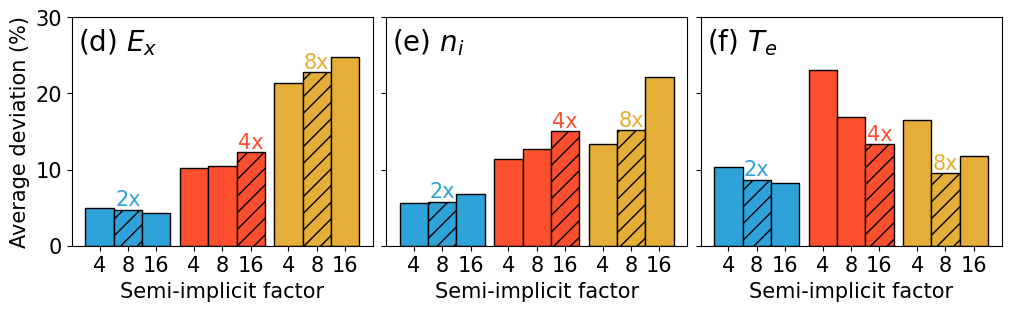

In [257]:
plot_deviations('si', 'def', show=True)

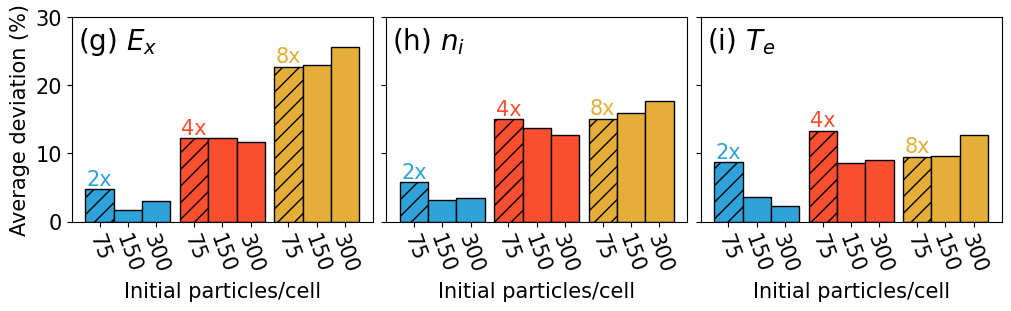

In [258]:
plot_deviations('ppc', 'ghi', show=True)

In [283]:
sims = ['g1-dt1-si0-ppc75-r200', 'g1-dt1-si0-ppc75-r250', 'g1-dt1-si0-ppc75']

def _load_evdf_data(dir):
    data = np.genfromtxt(Path(dir) / 'output'/ 'vdf'/ 'vdf_electrons_right.csv', delimiter=',', skip_header=1)
    return {'ux': data[:, 0], 'fx': data[:, 1], 'uy': data[:, 2], 'fy': data[:, 3], 'uz': data[:, 4], 'fz': data[:, 5]}

def plot_evdfs(axis='x', show=True):
    fig, ax = plt.subplots(1, 1, figsize = (5, 4), layout = 'constrained', sharey = True)

    evdf_data = [_load_evdf_data(data_dir / dir) for dir in sims]
    formatter = mticker.ScalarFormatter(useMathText=True)
    ax.yaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_formatter(formatter)

    full_names = {'x': 'Axial', 'y': 'Radial', 'z': 'Azimuthal'}
    ax.set_xlabel(f"{full_names[axis]} electron velocity [m/s]")
    ax.set_ylabel("Probability density [arb.]")
    ax.set_yticks([])
    ax.set_xlim(-0.75e7, 0.75e7)


    resampling = ["200 ppc", "250 ppc", "None"]
    for i, (data, resample, color) in enumerate(zip(evdf_data, resampling, reversed(colors[:3]))):
        u = data[f'u{axis}']
        f = data[f'f{axis}']
        integral = -np.trapz(u, f)
        ax.plot(u, f/integral, color=color, label=resample, linewidth=2, zorder=i)
        

    if axis=='z':
        ax.legend()

    save_fig(fig, f"evdf_{axis}", **savefig_args)
    
    if show:
        plt.show()
    else:
        plt.close(fig)

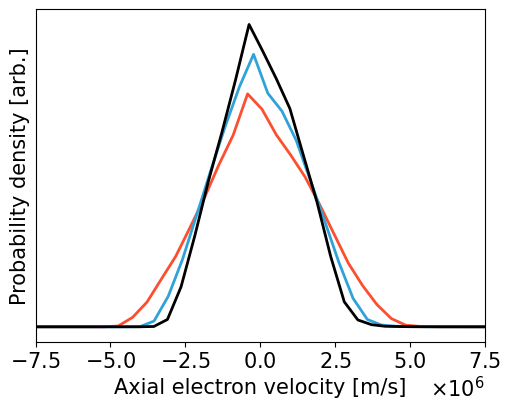

In [284]:
plot_evdfs('x', show=True)

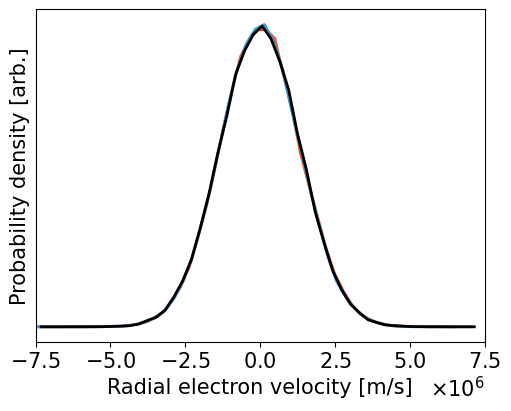

In [285]:
plot_evdfs('y', show=True)

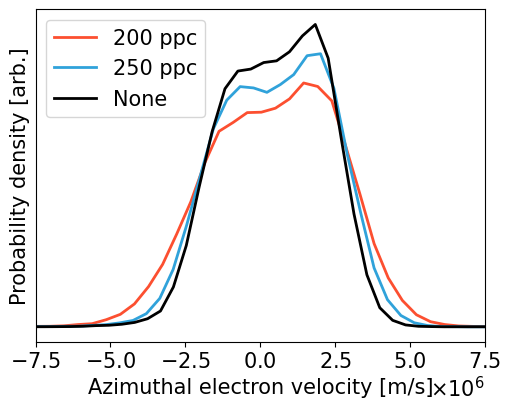

In [286]:
plot_evdfs('z', show=True)